## Ensayos usando la libreria libEMG

## Sobre la libreria

* **Paper**: LibEMG: An Open Source Library to Facilitate the Exploration of Myoelectric Control ([link](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10214558))
* **Repo**: https://github.com/LibEMG/libemg

Modulos: 
1. Data Handling
2. Filtering
3. Feature Extraction
4. Feature Selection
5. Classification
6. Evaluation

En teoria la libreria se logro instalar con exito.

Instalar para evitar warnings

```
pip install --upgrade paramiko
pip install --upgrade cryptography
```

Con eso ya no salen las advertencias.

In [178]:
try:
    import libemg
    print("La librería 'libEMG' está instalada y se ha importado correctamente.")
except ImportError:
    print("La librería 'libEMG' no está instalada.")

La librería 'libEMG' está instalada y se ha importado correctamente.


Se importa el dataset a analizar mediante el OfflineDataHandler.

In [236]:
import os
import requests
from tqdm import tqdm
import os
import zipfile
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [180]:
from libemg.datasets import *

In [19]:
datasets = get_dataset_list()
datasets

{'OneSubjectMyo': libemg._datasets.one_subject_myo.OneSubjectMyoDataset,
 '3DC': libemg._datasets._3DC._3DCDataset,
 'MinimalTrainingData': libemg._datasets.ciil.CIIL_MinimalData,
 'ElectrodeShift': libemg._datasets.ciil.CIIL_ElectrodeShift,
 'GRABMyoBaseline': libemg._datasets.grab_myo.GRABMyoBaseline,
 'GRABMyoCrossDay': libemg._datasets.grab_myo.GRABMyoCrossDay,
 'ContinuousTransitions': libemg._datasets.continous_transitions.ContinuousTransitions,
 'NinaProDB2': libemg._datasets.nina_pro.NinaproDB2,
 'FORS-EMG': libemg._datasets.fors_emg.FORSEMG,
 'EMGEPN612': libemg._datasets.emg_epn612.EMGEPN_UserDependent,
 'ContractionIntensity': libemg._datasets.intensity.ContractionIntensity,
 'RadmandLP': libemg._datasets.radmand_lp.RadmandLP,
 'FougnerLP': libemg._datasets.fougner_lp.FougnerLP,
 'KaufmannMD': libemg._datasets.kaufmann_md.KaufmannMD,
 'TMR_Post': libemg._datasets.tmr_shirleyryanabilitylab.TMR_Post,
 'TMR_Pre': libemg._datasets.tmr_shirleyryanabilitylab.TMR_Pre,
 'HyserPR': l

In [20]:
get_dataset_info('NinaProDB2')

NinaProb DB2.
Sampling Rate: 2000
Number of Channels: 12
Device: Delsys
Gestures: {0: 'See Exercises B and C from: https://ninapro.hevs.ch/instructions/DB2.html'}
Number of Reps: 4 Train, 2 Test
Number of Subjects: 40
Citation: https://ninapro.hevs.ch/


Se puede mirar si podemos hacer lo mismo con el dataset Ninapro DB1: 
* https://libemg.github.io/libemg/examples/simple_offline_example/simple_offline_example.html
* https://libemg.github.io/libemg/documentation/data/data.html#offline-data-handler

In [21]:
from libemg.datasets import NinaproDB2
dataset_Ninapro_DB2 = NinaproDB2()

In [22]:
dataset_Ninapro_DB2.get_info()

NinaProb DB2.
Sampling Rate: 2000
Number of Channels: 12
Device: Delsys
Gestures: {0: 'See Exercises B and C from: https://ninapro.hevs.ch/instructions/DB2.html'}
Number of Reps: 4 Train, 2 Test
Number of Subjects: 40
Citation: https://ninapro.hevs.ch/


## Funciones para descarga de bases de datos de Ninapro

Estas fueron hechas por Skynet.

In [23]:
def create_directory(path: str) -> None:
    """
    Crea un directorio si no existe.

    :param path: Ruta del directorio a crear.
    """
    os.makedirs(path, exist_ok=True)


def download_file(url: str, output_path: str) -> None:
    """
    Descarga un archivo desde una URL y lo guarda en la ruta especificada.

    :param url: URL completa del archivo a descargar.
    :param output_path: Ruta local donde se guardará el archivo.
    """
    try:
        response = requests.get(url, stream=True, timeout=10)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=1024), desc=os.path.basename(output_path), unit='KB'):
                    if chunk:
                        f.write(chunk)
            print(f'Descarga completa: {os.path.basename(output_path)}')
        else:
            print(f'Archivo no encontrado en: {url}')
    except requests.exceptions.RequestException as e:
        print(f'Error al descargar {os.path.basename(output_path)}: {e}')

def extract_all_zip_files(zip_dir: str, extract_dir: str) -> None:
    """
    Extrae todos los archivos .zip de un directorio a subcarpetas organizadas.

    :param zip_dir: Directorio donde están los archivos .zip
    :param extract_dir: Directorio donde se extraerán los archivos
    """
    create_directory(extract_dir)

    zip_files = [f for f in os.listdir(zip_dir) if f.endswith('.zip')]

    for zip_file in zip_files:
        zip_path = os.path.join(zip_dir, zip_file)
        subject_folder = os.path.join(extract_dir, zip_file.replace('.zip', ''))

        if os.path.exists(subject_folder):
            print(f'{subject_folder} ya extraído. Omitiendo.')
            continue

        print(f'Extrayendo {zip_file}...')
        create_directory(subject_folder)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(subject_folder)

        print(f'Extracción completa: {subject_folder}')


La siguiente función debe ser actualizada para que generalice el patron.

In [24]:
def download_ninapro_dataset(db_name: str,
                              data_type: str = None,
                              start: int = 1,
                              end: int = 40,
                              output_dir: str = None) -> None:
    """
    Descarga archivos sX.zip de cualquier base de datos Ninapro. (OJO: Actualizar a DBX_zzz)

    :param db_name: Nombre de la base de datos (Ejemplo: 'DB1', 'DB2', 'DB3').
    :param data_type: Tipo de datos a descargar ('Preproc' o 'Raw').
    :param start: Número inicial de archivo a descargar (por defecto 1).
    :param end: Número final de archivo a descargar (por defecto 40).
    :param output_dir: Carpeta local donde se guardarán los archivos. Si no se indica, se crea automáticamente.
    """
    # assert data_type in ['Preproc', 'Raw'], "data_type debe ser 'Preproc' o 'Raw'"

    base_url = f'https://ninapro.hevs.ch/files/{db_name}/{data_type}/'
    print(base_url)

    if output_dir is None:
        output_dir = f'ninapro_{db_name}_{data_type}'
    
    create_directory(output_dir)

    for i in range(start, end + 1):
        file_name = f's{i}.zip'
        output_path = os.path.join(output_dir, file_name)

        if os.path.exists(output_path):
            print(f'{file_name} ya existe. Descarga omitida.')
            continue

        file_url = base_url + file_name
        print(f'Descargando {file_name}...')
        download_file(file_url, output_path)

Invocacion de la funcion para descargar el dataset

In [ ]:
# Se descargo el dataset DB1 
download_ninapro_dataset('DB1', 'Preprocessed', 1, 27, 'ninapro_DB1_raw')

https://ninapro.hevs.ch/files/DB1/Preprocessed/
s1.zip ya existe. Descarga omitida.
s2.zip ya existe. Descarga omitida.
s3.zip ya existe. Descarga omitida.
s4.zip ya existe. Descarga omitida.
s5.zip ya existe. Descarga omitida.
s6.zip ya existe. Descarga omitida.
s7.zip ya existe. Descarga omitida.
s8.zip ya existe. Descarga omitida.
s9.zip ya existe. Descarga omitida.
s10.zip ya existe. Descarga omitida.
s11.zip ya existe. Descarga omitida.
s12.zip ya existe. Descarga omitida.
s13.zip ya existe. Descarga omitida.
s14.zip ya existe. Descarga omitida.
s15.zip ya existe. Descarga omitida.
s16.zip ya existe. Descarga omitida.
s17.zip ya existe. Descarga omitida.
s18.zip ya existe. Descarga omitida.
s19.zip ya existe. Descarga omitida.
s20.zip ya existe. Descarga omitida.
s21.zip ya existe. Descarga omitida.
s22.zip ya existe. Descarga omitida.
s23.zip ya existe. Descarga omitida.
s24.zip ya existe. Descarga omitida.
s25.zip ya existe. Descarga omitida.
s26.zip ya existe. Descarga omitida.

Funcion que extrae los archivos descargados

In [25]:
def extract_all_zip_files(zip_dir: str, extract_dir: str) -> None:
    """
    Extrae todos los archivos .zip de un directorio en subcarpetas con el mismo nombre del archivo.

    :param zip_dir: Ruta donde están los archivos .zip.
    :param extract_dir: Ruta donde se extraerán los archivos.
    """
    if not os.path.exists(zip_dir):
        raise ValueError(f'El directorio {zip_dir} no existe.')

    os.makedirs(extract_dir, exist_ok=True)

    zip_files = [f for f in os.listdir(zip_dir) if f.endswith('.zip')]

    if not zip_files:
        print(f'No se encontraron archivos .zip en {zip_dir}')
        return

    for zip_file in zip_files:
        zip_path = os.path.join(zip_dir, zip_file)
        folder_name = os.path.splitext(zip_file)[0]
        output_path = os.path.join(extract_dir, folder_name)

        if os.path.exists(output_path):
            print(f'El archivo {zip_file} ya fue extraído. Omitiendo.')
            continue

        print(f'Extrayendo {zip_file}...')

        os.makedirs(output_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)

        print(f'Extracción completa: {output_path}')

In [13]:
extract_all_zip_files(
    zip_dir='ninapro_DB1_raw',               # Directorio donde están los .zip
    extract_dir='ninapro_DB1_raw_unzip'  # Carpeta destino para extracción
)

El archivo s1.zip ya fue extraído. Omitiendo.
El archivo s10.zip ya fue extraído. Omitiendo.
El archivo s11.zip ya fue extraído. Omitiendo.
El archivo s12.zip ya fue extraído. Omitiendo.
El archivo s13.zip ya fue extraído. Omitiendo.
El archivo s14.zip ya fue extraído. Omitiendo.
El archivo s15.zip ya fue extraído. Omitiendo.
El archivo s16.zip ya fue extraído. Omitiendo.
El archivo s17.zip ya fue extraído. Omitiendo.
El archivo s18.zip ya fue extraído. Omitiendo.
El archivo s19.zip ya fue extraído. Omitiendo.
El archivo s2.zip ya fue extraído. Omitiendo.
El archivo s20.zip ya fue extraído. Omitiendo.
El archivo s21.zip ya fue extraído. Omitiendo.
El archivo s22.zip ya fue extraído. Omitiendo.
El archivo s23.zip ya fue extraído. Omitiendo.
El archivo s24.zip ya fue extraído. Omitiendo.
El archivo s25.zip ya fue extraído. Omitiendo.
El archivo s26.zip ya fue extraído. Omitiendo.
El archivo s27.zip ya fue extraído. Omitiendo.
El archivo s3.zip ya fue extraído. Omitiendo.
El archivo s4.zi

Teniendo en cuenta el siguiente codigo ([link](https://libemg.github.io/libemg/documentation/data/data.html#offline-data-handler)) para generar la busqueda usando la siguiente expresión regular `dataset/train/R_1_C_1_EMG.csv`

```py
dataset_folder = 'dataset'
regex_filters = [
    RegexFilter(left_bound = "dataset/", right_bound="/", values = sets_values, description='sets'),
    RegexFilter(left_bound = "_C_", right_bound="_EMG.csv", values = classes_values, description='classes'),
    RegexFilter(left_bound = "R_", right_bound="_C_", values = reps_values, description='reps')
]
odh = OfflineDataHandler()
odh.get_data(folder_location=dataset_folder, regex_filters=regex_filters, delimiter=",")
```

In [29]:
# Función para convertir .mat a .csv
def convert_mat_to_csv(input_dir, output_dir):
    """
    Convierte todos los archivos .mat de un directorio a archivos .csv.

    Parámetros:
        input_dir (str): Ruta de los archivos .mat
        output_dir (str): Ruta donde se guardarán los archivos .csv
    """
    os.makedirs(output_dir, exist_ok=True)

    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.mat'):
                mat_path = os.path.join(root, file)
                mat_data = scipy.io.loadmat(mat_path)

                for key in mat_data:
                    # print(key)
                    if not key.startswith('__'):
                        data = mat_data[key]

                        if isinstance(data, (list, tuple, dict)):
                            continue
                        if hasattr(data, 'shape'):
                            df = pd.DataFrame(data)
                            output_csv = os.path.join(
                                output_dir, f'{file.replace(".mat", "")}_{key}.csv')
                            df.to_csv(output_csv, index=False)
                            print(f'Guardado: {output_csv}')

In [30]:
input_dir = 'ninapro_DB1_raw_unzip'
output_dir = 'ninapro_DB1_raw_csv'
convert_mat_to_csv(input_dir, output_dir)

Guardado: ninapro_DB1_raw_csv\S1_A1_E1_emg.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_stimulus.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_glove.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_subject.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_exercise.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_repetition.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_restimulus.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E1_rerepetition.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_emg.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_stimulus.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_glove.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_subject.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_exercise.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_repetition.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_restimulus.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E2_rerepetition.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E3_emg.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E3_stimulus.csv
Guardado: ninapro_DB1_raw_csv\S1_A1_E3_glove.csv
Guardado: ninapro_DB1_

In [223]:
from libemg.data_handler import OfflineDataHandler, RegexFilter

END_SUBJECT = 1

dataset_folder = 'ninapro_DB1_raw_csv'  # Carpeta donde están los archivos extraídos
subjects_values = [str(i) for i in range(1, END_SUBJECT + 1)] # Lista de sujetos a filtrar (s1 a s26)
actions_values = ['1'] # Por ahora solo con la primera adquisición
exercises_values = ['1'] # Por ahora solo con el primero ejercicio

In [227]:
# Definir los filtros RegEx para extraer metadatos del nombre de archivo
emg_filters_emg = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_emg.csv", values = exercises_values, description='exercise')
]

emg_odh = OfflineDataHandler()
emg_odh.get_data(folder_location = dataset_folder, regex_filters = emg_filters_emg, delimiter=",")

1 data files fetched out of 648 files.


In [228]:
regex_filters_restimulus = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_restimulus.csv", values = exercises_values, description='exercise')  
]

restimulus_odh = OfflineDataHandler()
restimulus_odh.get_data(folder_location = dataset_folder, regex_filters = regex_filters_restimulus, delimiter=",")

1 data files fetched out of 648 files.


In [229]:
rerepetition_regex_filters = [
    RegexFilter(left_bound = "/S", right_bound="_", values = subjects_values, description='subject'),
    RegexFilter(left_bound = "A", right_bound="_", values = actions_values, description='action'),
    RegexFilter(left_bound = "E", right_bound="_rerepetition.csv", values = exercises_values, description='exercise')   
]

rerepetition_odh = OfflineDataHandler()
rerepetition_odh.get_data(folder_location = dataset_folder, regex_filters = rerepetition_regex_filters, delimiter=",")

1 data files fetched out of 648 files.


### Sujeto 1

#### Obtencion de los datos

In [255]:
# Por ejemplo, obtener solo los datos del sujeto 1
emg_s1 = emg_odh.isolate_data(key="subject", values=[0]).data[0]
print(emg_s1.shape)
rerepetition_s1 = rerepetition_odh.isolate_data(key="subject", values=[0]).data[0]
print(rerepetition_s1.shape)
restimulus_s1 = restimulus_odh.isolate_data(key="subject", values=[0]).data[0]
print(restimulus_s1.shape)


(101015, 10)
(101015, 1)
(101015, 1)


Se elimina la fila de los labels. Como primer ensayo se hace para la señal emg solamente.

In [354]:
emg_s1 = emg_s1[1:]
emg_s1

array([[0.0684, 0.0024, 0.0024, ..., 0.0488, 0.0024, 0.0342],
       [0.0586, 0.0024, 0.0024, ..., 0.0415, 0.0024, 0.0293],
       [0.0562, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0244],
       ...,
       [0.0024, 0.0024, 0.0024, ..., 0.0342, 0.0024, 0.0073],
       [0.0024, 0.0024, 0.0024, ..., 0.0366, 0.0024, 0.0073],
       [0.0024, 0.0024, 0.0024, ..., 0.0391, 0.0024, 0.0024]])

In [355]:
emg_s1.shape

(101014, 10)

Se repite el procedimiento para las demas señales.

In [356]:
rerepetition_s1 = rerepetition_s1[1:]
restimulus_s1 = restimulus_s1[1:]

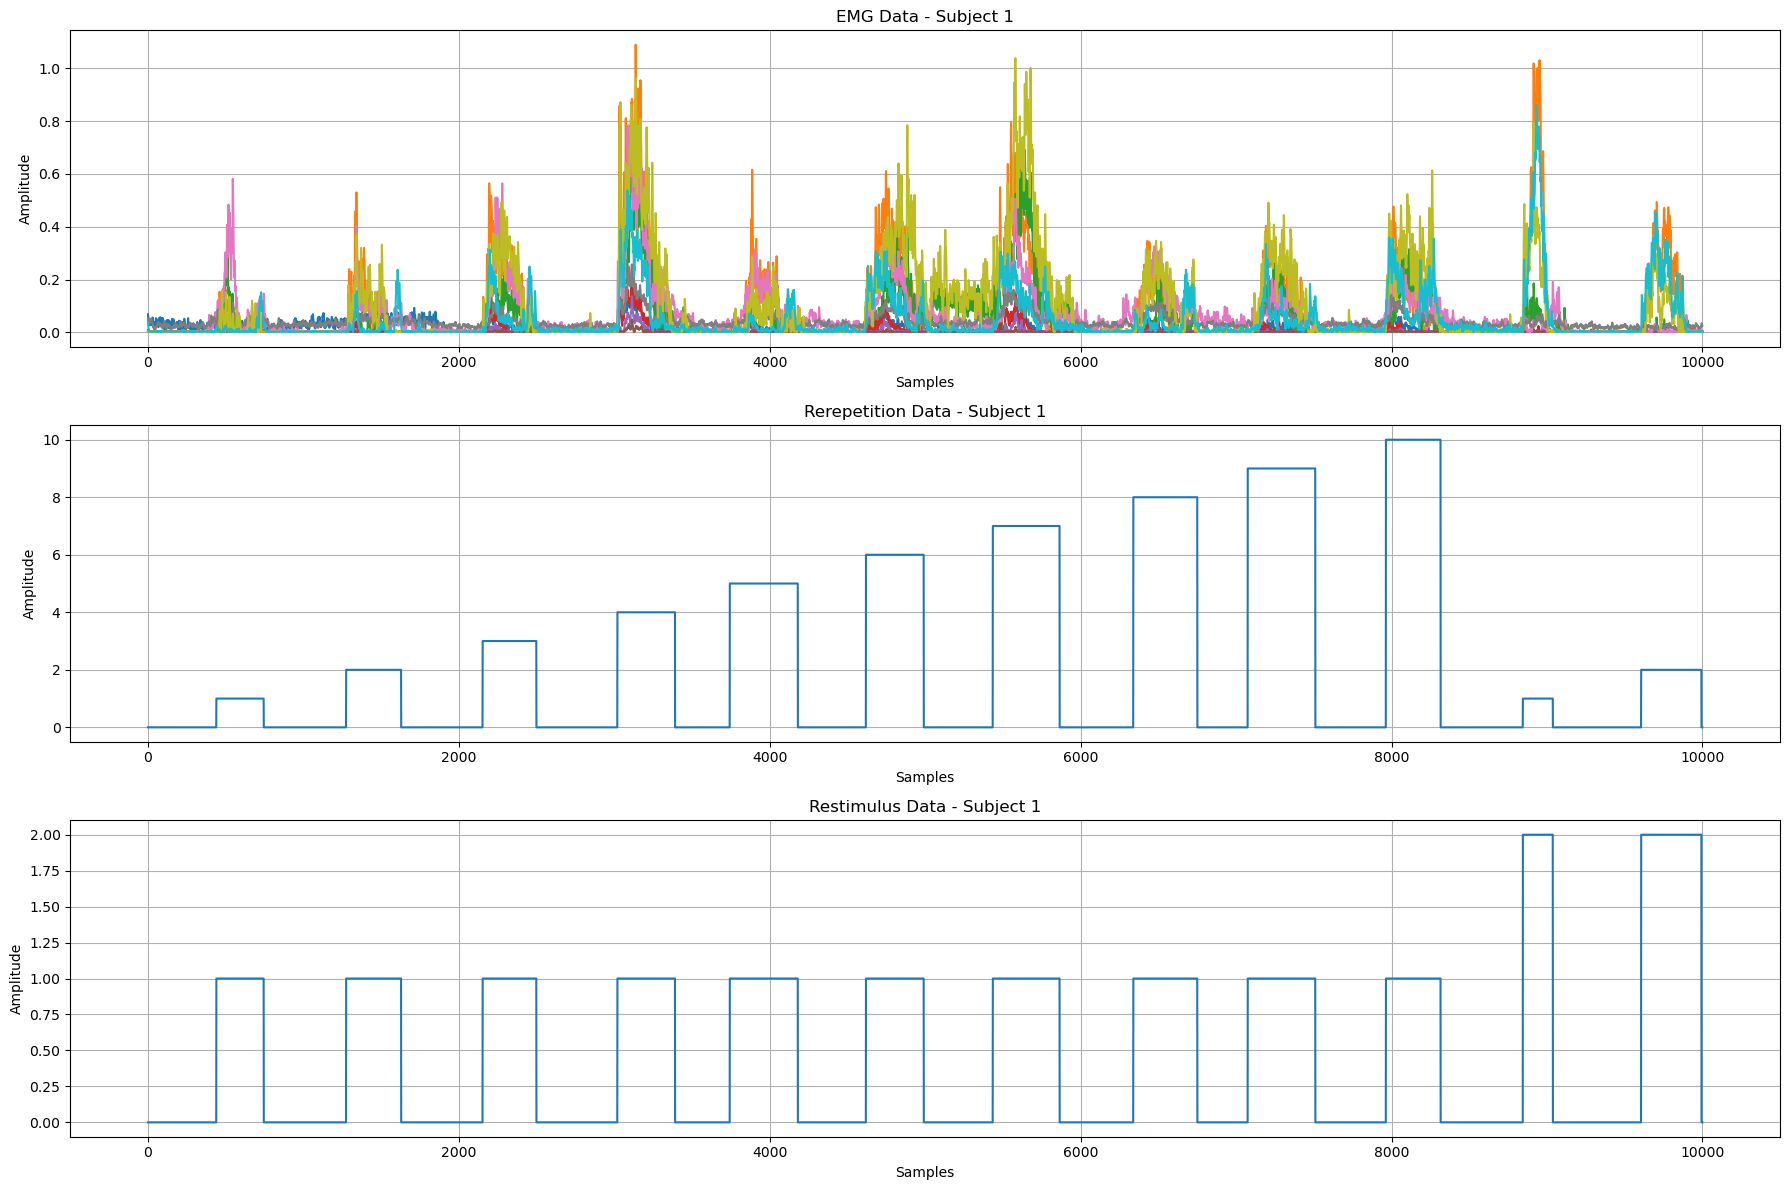

In [357]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg_s1[:10000])  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Segundo subplot para rerepetition_s1
plt.subplot(3, 1, 2)
plt.plot(rerepetition_s1[:10000])  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Tercer subplot para restimulus_s1
plt.subplot(3, 1, 3)
plt.plot(restimulus_s1[:10000])  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

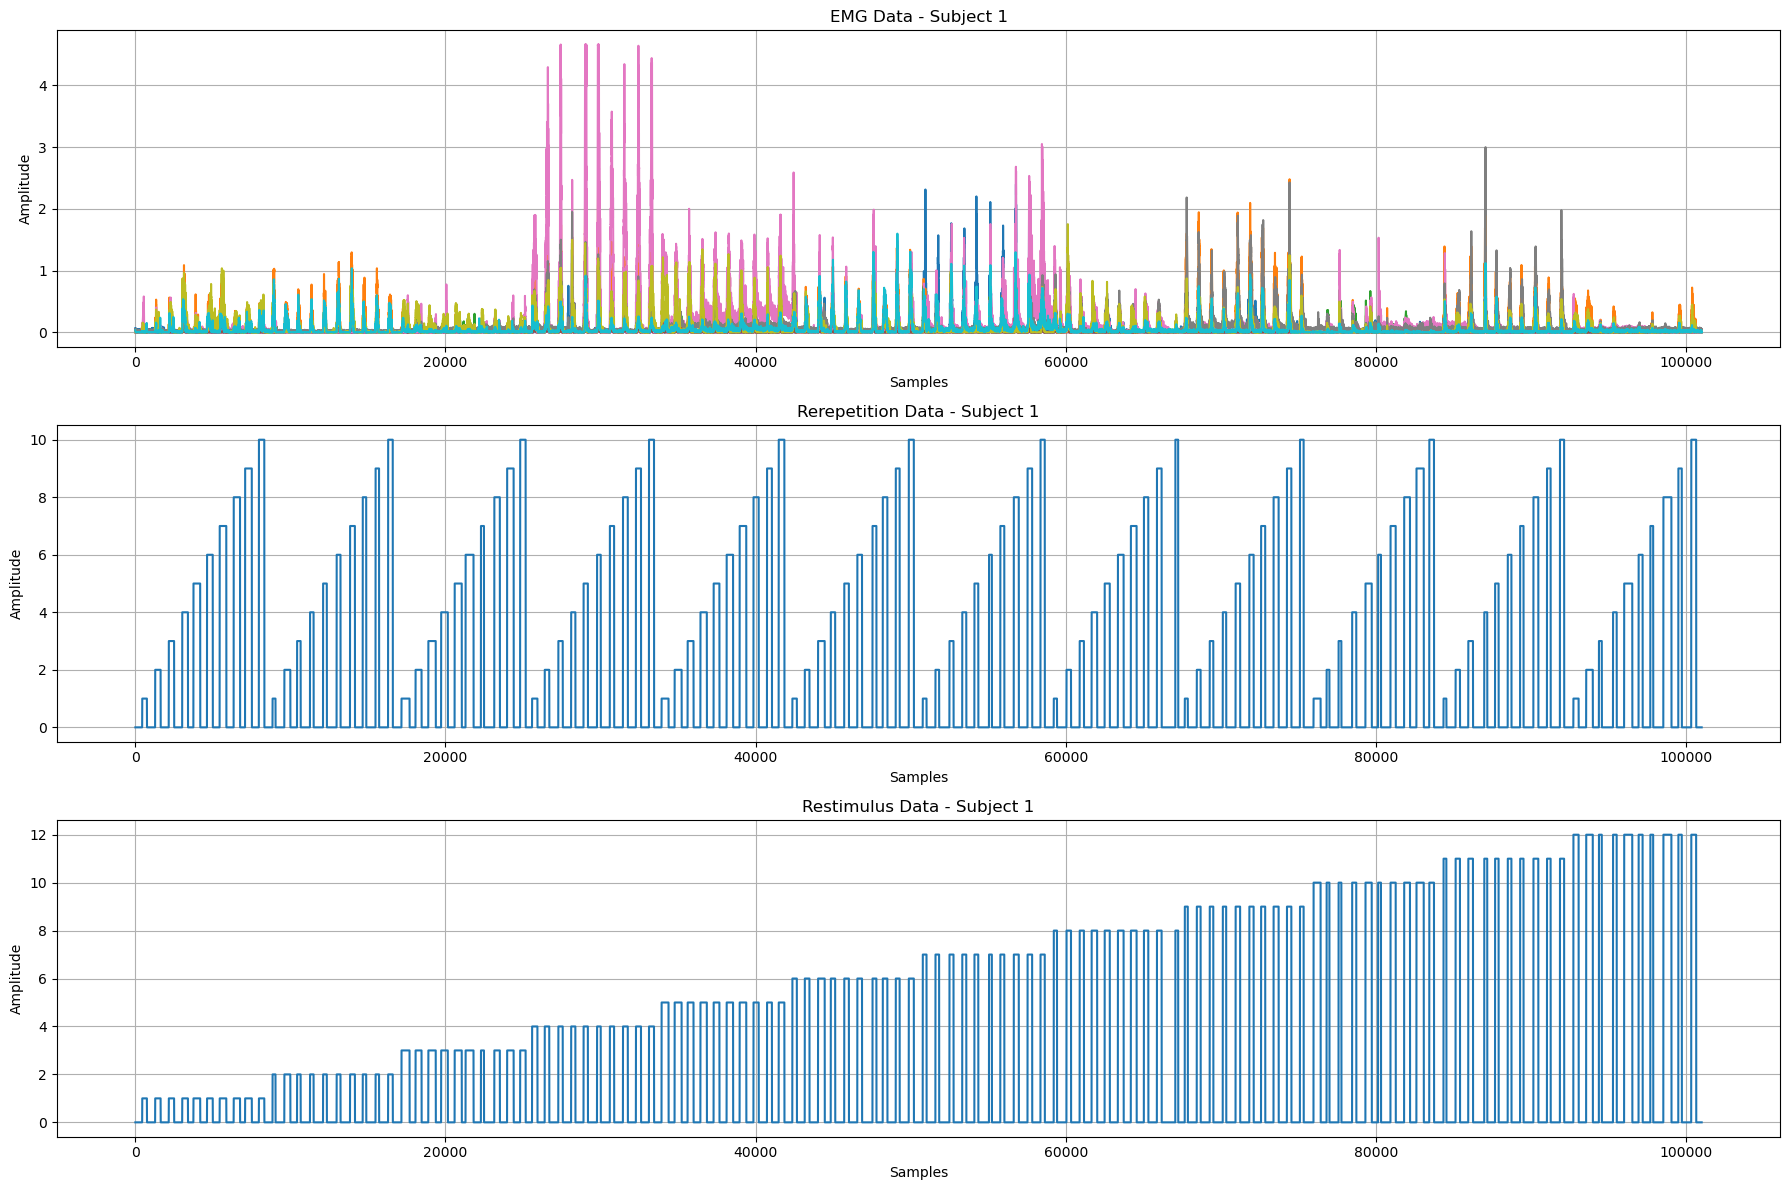

In [358]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg_s1)  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Segundo subplot para rerepetition_s1
plt.subplot(3, 1, 2)
plt.plot(rerepetition_s1)  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Tercer subplot para restimulus_s1
plt.subplot(3, 1, 3)
plt.plot(restimulus_s1)  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Filtrado

In [359]:
# create a filter for low frequency motion artefacts
lowpass_filter_100Hz ={ "name": "lowpass", "cutoff": 1, "order":2}

In [360]:
# instantiate the filter object with the sampling frequency
f_sampling = 100
fi = libemg.filtering.Filter(f_sampling)
fi.install_filters(filter_dictionary = lowpass_filter_100Hz)

In [361]:
fi.sampling_frequency

100

In [362]:
emg_s1_filter = fi.filter(emg_s1)

In [363]:
print(emg_s1_filter.shape)

(101014, 10)


In [364]:
emg_s1_filter

array([[0.06752279, 0.00240159, 0.00239855, ..., 0.05035747, 0.0024    ,
        0.03419234],
       [0.06628393, 0.00240207, 0.00240184, ..., 0.04970653, 0.0024    ,
        0.03281989],
       [0.06504509, 0.00240258, 0.00240519, ..., 0.04905012, 0.0024    ,
        0.03145152],
       ...,
       [0.00283771, 0.00239999, 0.00248482, ..., 0.04868185, 0.0024    ,
        0.01179218],
       [0.00283664, 0.00239999, 0.00248407, ..., 0.04863274, 0.0024    ,
        0.01174193],
       [0.00283566, 0.0024    , 0.00248343, ..., 0.04859011, 0.0024    ,
        0.01169783]])

##### Grafica de la señal filtrada

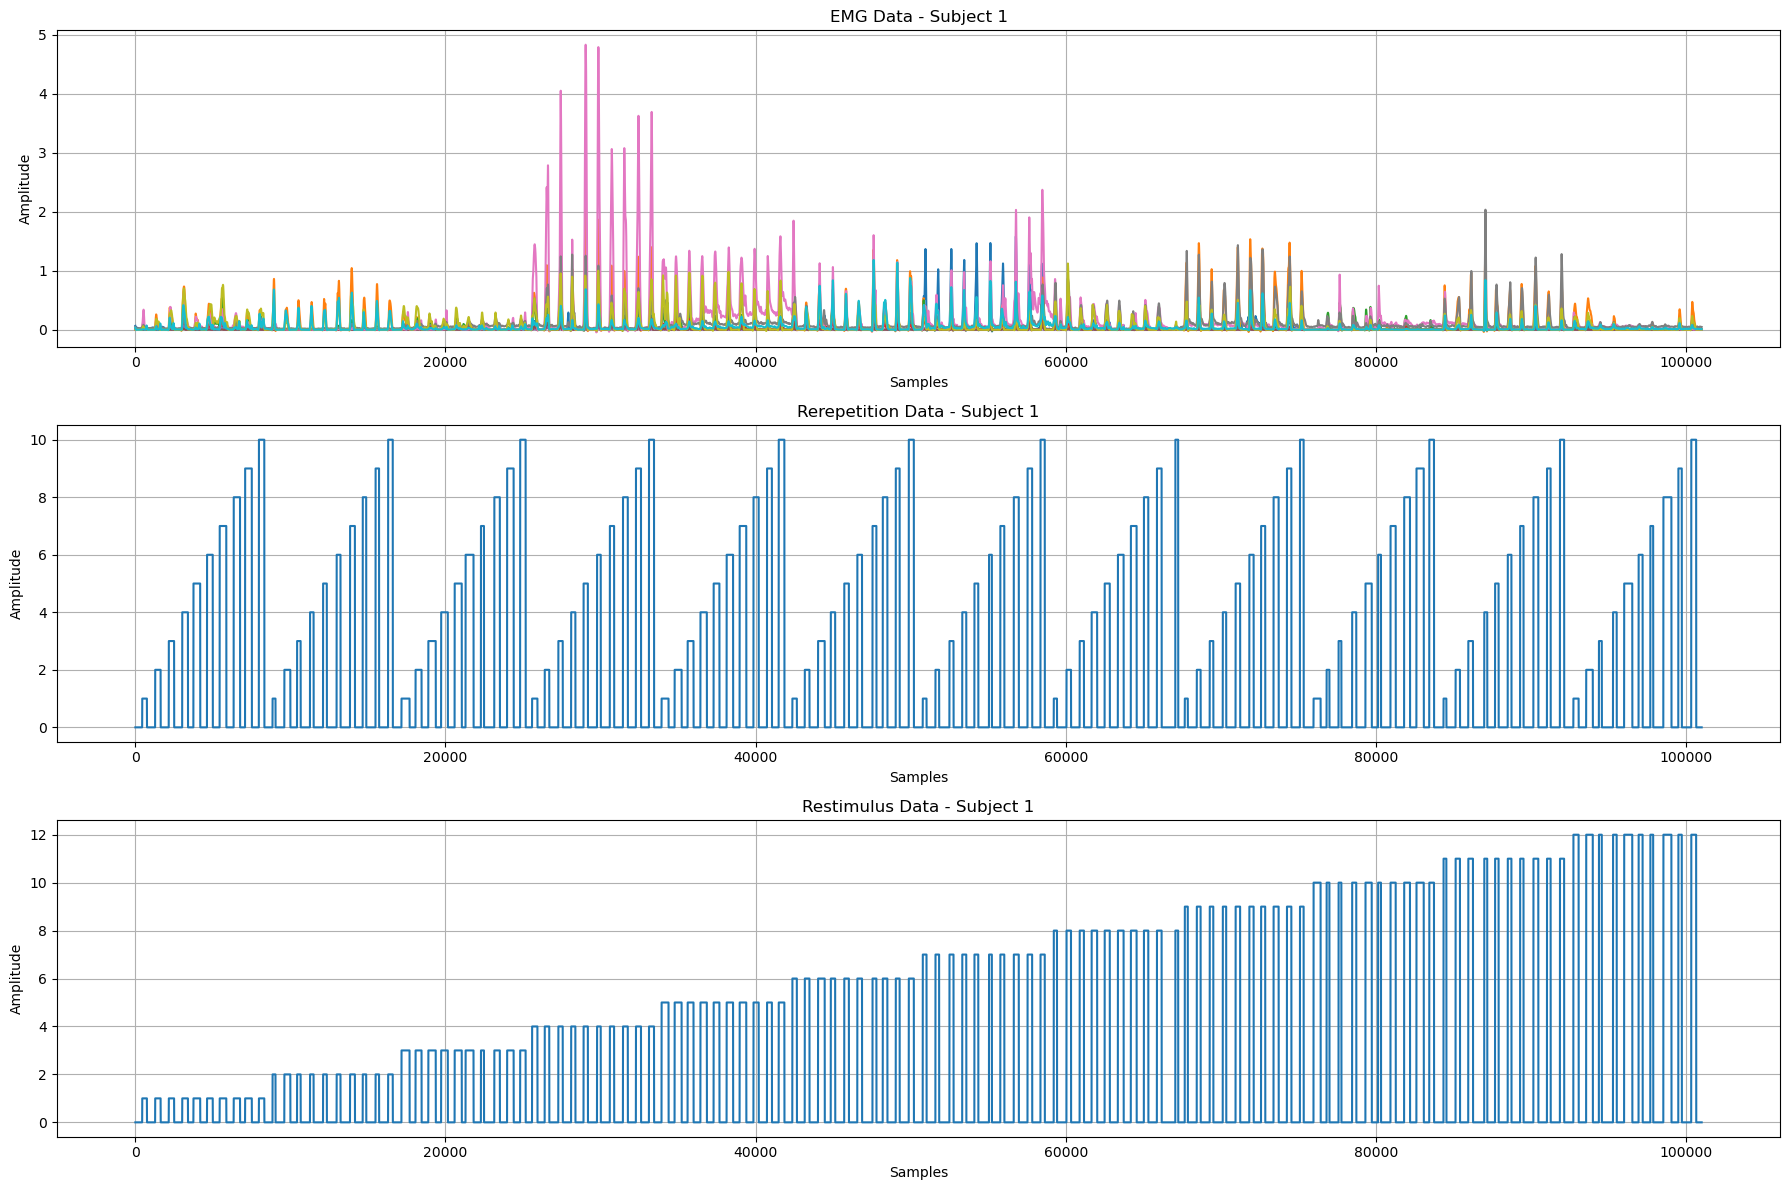

In [365]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg_s1_filter)  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Segundo subplot para rerepetition_s1
plt.subplot(3, 1, 2)
plt.plot(rerepetition_s1)  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Tercer subplot para restimulus_s1
plt.subplot(3, 1, 3)
plt.plot(restimulus_s1)  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

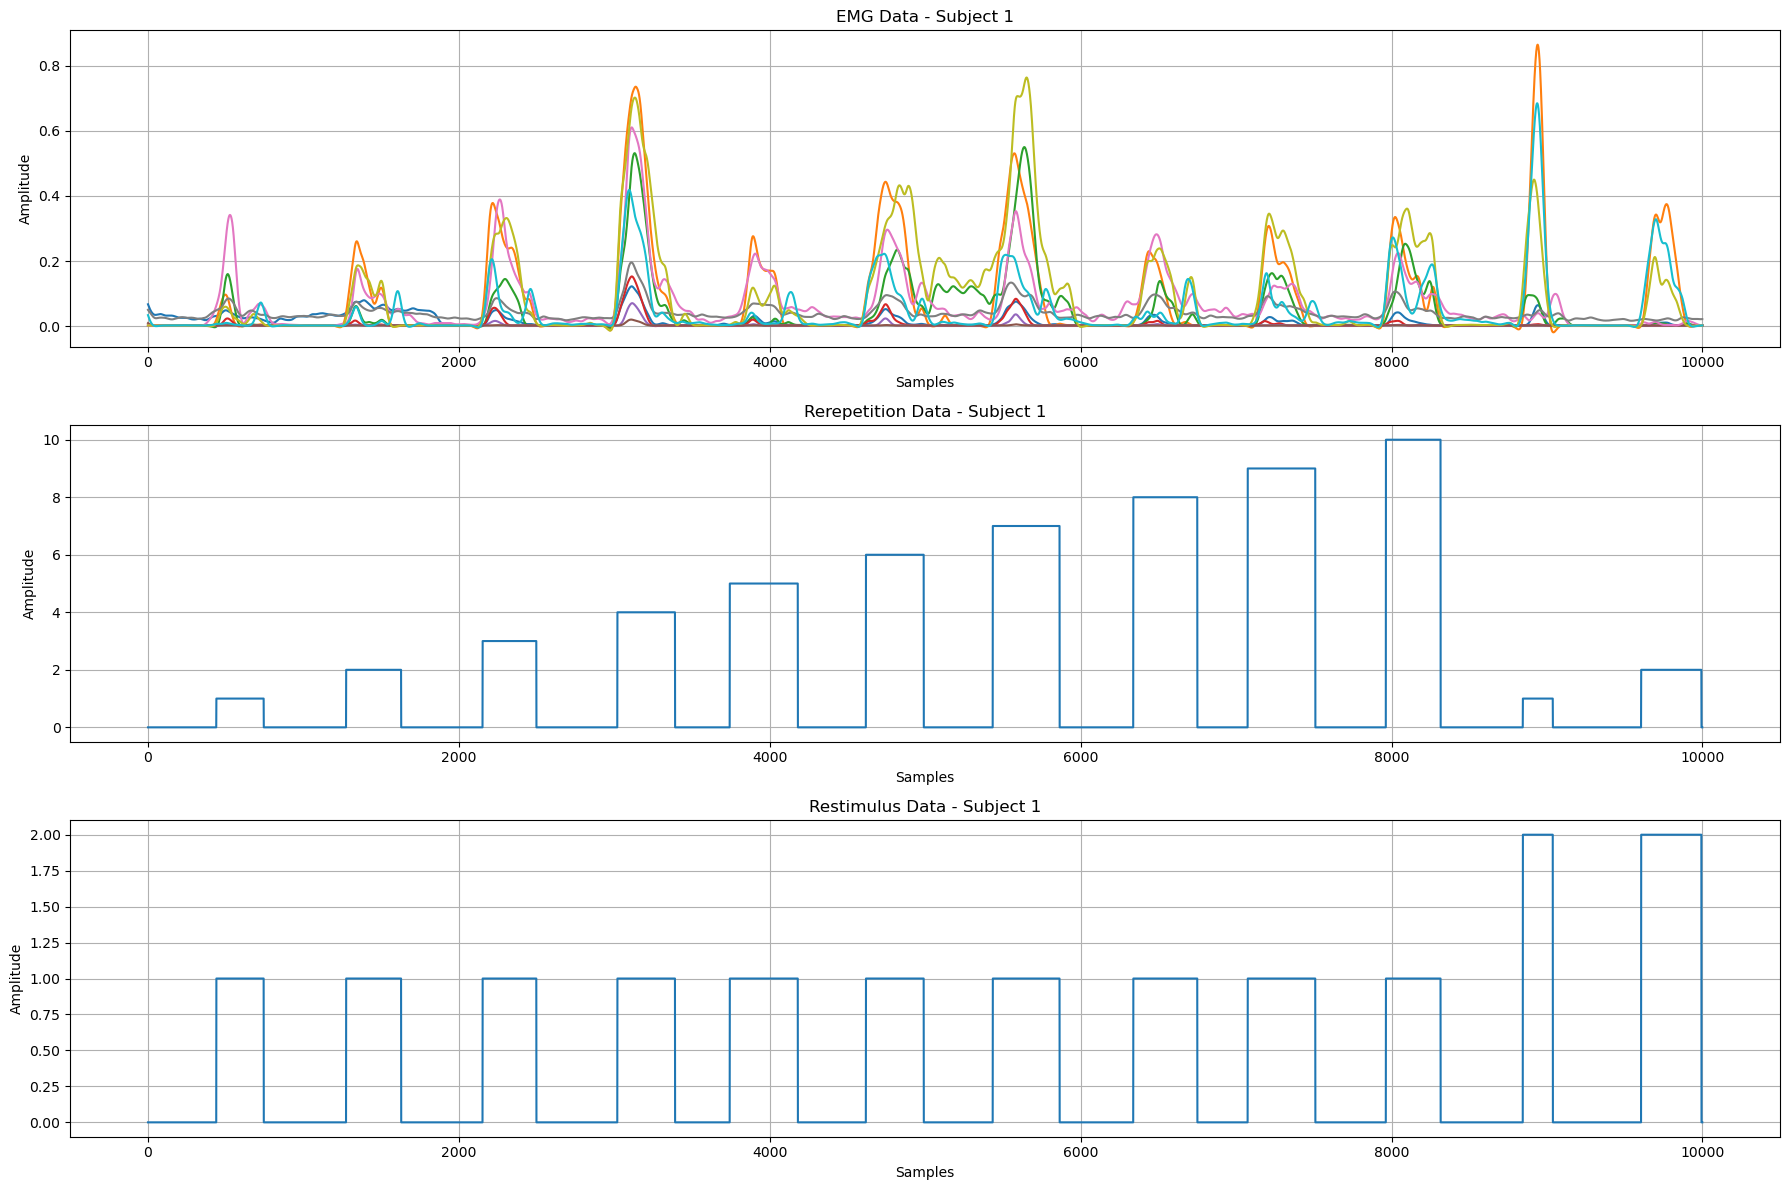

In [366]:
plt.figure(figsize=(18, 12))

# Primer subplot para emg_s1
plt.subplot(3, 1, 1)
plt.plot(emg_s1_filter[:10000])  # Muestra los primeros 10,000 puntos
plt.title("EMG Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Segundo subplot para rerepetition_s1
plt.subplot(3, 1, 2)
plt.plot(rerepetition_s1[:10000])  # Muestra los primeros 10,000 puntos
plt.title("Rerepetition Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

# Tercer subplot para restimulus_s1
plt.subplot(3, 1, 3)
plt.plot(restimulus_s1[:10000])  # Muestra los primeros 10,000 puntos
plt.title("Restimulus Data - Subject 1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

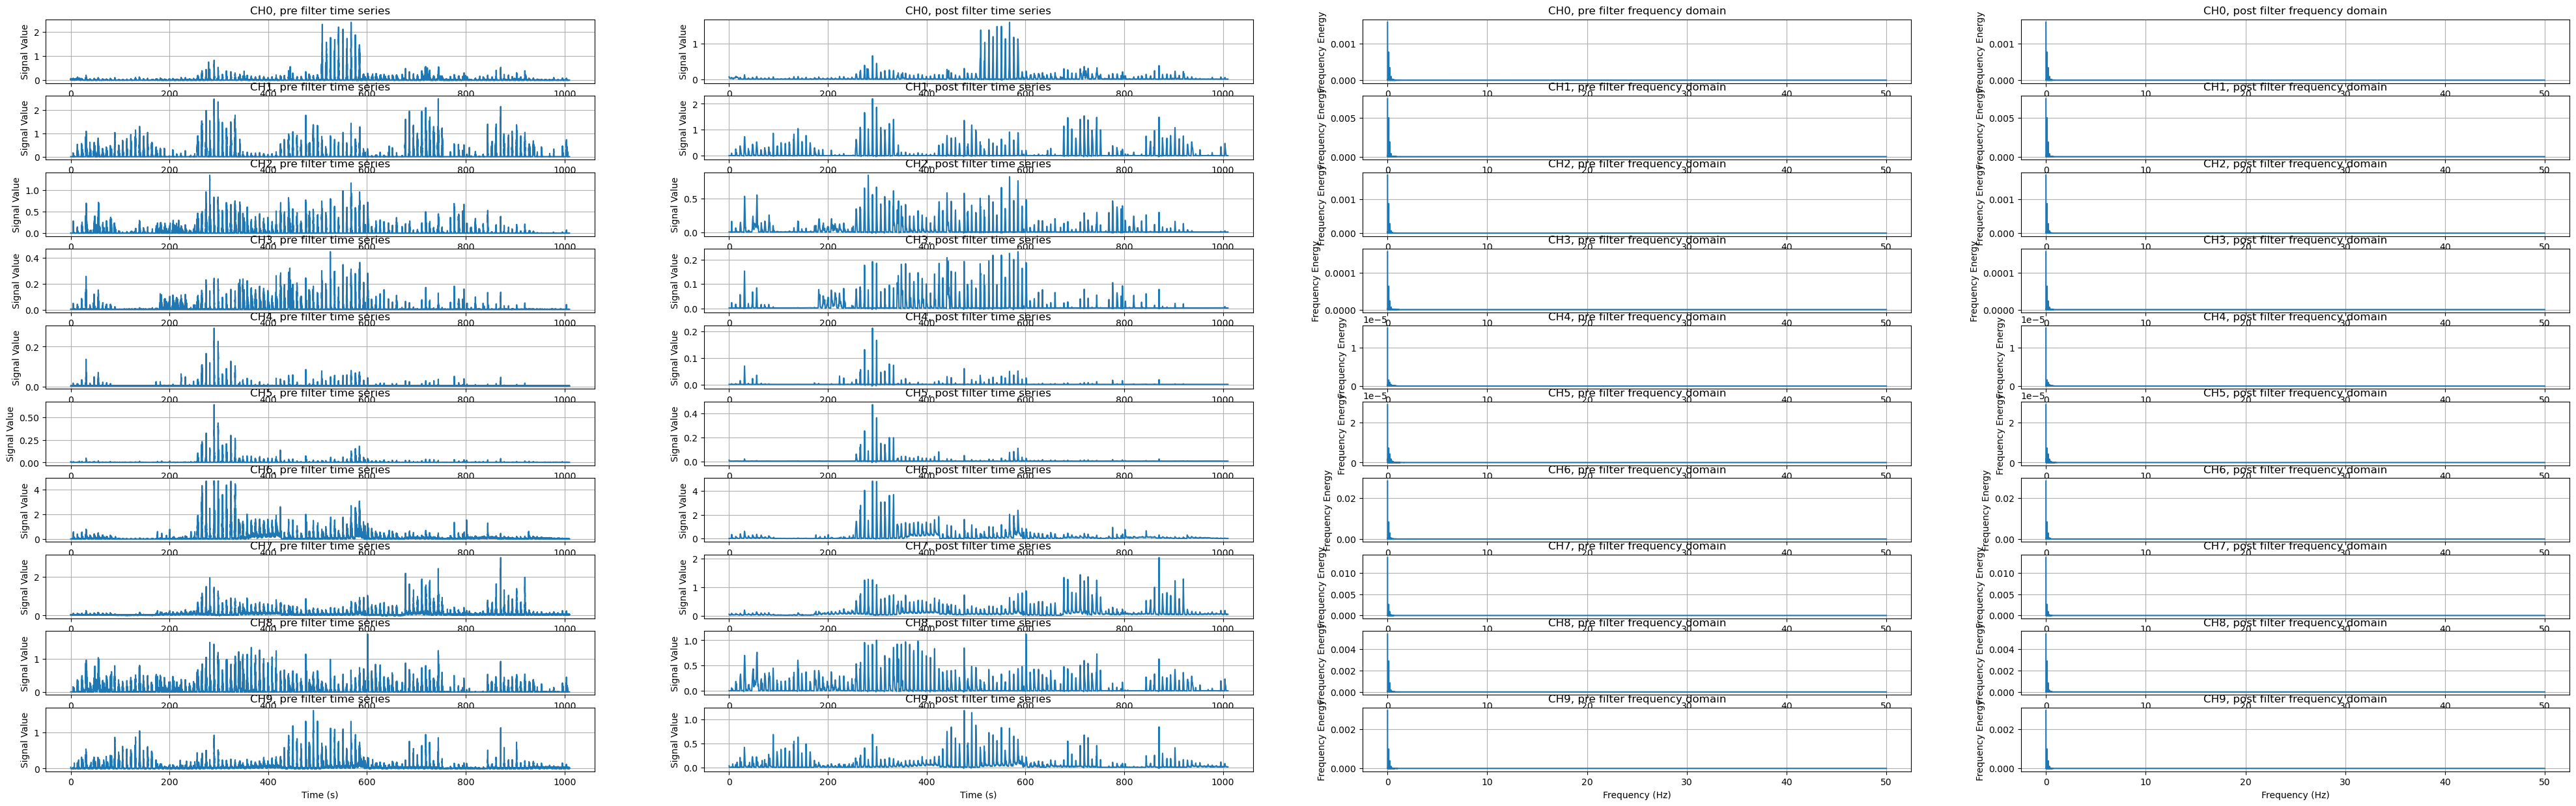

In [367]:
fi.visualize_effect(emg_s1)

### Extracción de caracteristicas

In [368]:
emg_s1_filter.shape

(101014, 10)

In [385]:
import numpy as np
from libemg.utils import get_windows

In [371]:
# Split the raw EMG into windows
windows = get_windows(emg_s1_filter, 30, 20)

In [372]:
windows.shape

(5050, 10, 30)

In [377]:
windows[0].shape

(10, 30)

In [384]:
windows[0:3,0] # Aqui se muestran superpuestas

array([[0.06752279, 0.06628393, 0.06504509, 0.06380968, 0.06258099,
        0.06136215, 0.06015613, 0.05896565, 0.05779326, 0.05664125,
        0.05551175, 0.05440669, 0.05332783, 0.05227676, 0.05125489,
        0.05026335, 0.04930299, 0.04837445, 0.04747821, 0.0466146 ,
        0.04578381, 0.0449859 , 0.04422083, 0.04348848, 0.04278863,
        0.04212095, 0.04148492, 0.04087992, 0.0403053 , 0.0397605 ],
       [0.04578381, 0.0449859 , 0.04422083, 0.04348848, 0.04278863,
        0.04212095, 0.04148492, 0.04087992, 0.0403053 , 0.0397605 ,
        0.03924512, 0.03875897, 0.03830207, 0.03787465, 0.03747704,
        0.0371096 , 0.03677262, 0.03646619, 0.03619019, 0.0359442 ,
        0.03572761, 0.03553964, 0.03537947, 0.03524631, 0.03513937,
        0.03505776, 0.03500047, 0.03496628, 0.03495371, 0.034961  ],
       [0.03572761, 0.03553964, 0.03537947, 0.03524631, 0.03513937,
        0.03505776, 0.03500047, 0.03496628, 0.03495371, 0.034961  ,
        0.03498618, 0.0350273 , 0.03508254, 0.

#### Extracción de caracteristicas

In [386]:
from libemg.feature_extractor import FeatureExtractor

In [387]:
fe = FeatureExtractor()

In [395]:
# Extract a list of features
feature_list1 = ['RMS']
feature_list2 = ['MAV', 'SSC', 'ZC', 'WL']
features_1 = fe.extract_features(feature_list1, windows)
features_2 = fe.extract_features(feature_list2, windows)

In [396]:
features_1.keys()

dict_keys(['RMS'])

In [398]:
features_1['RMS'].shape


(5050, 10)

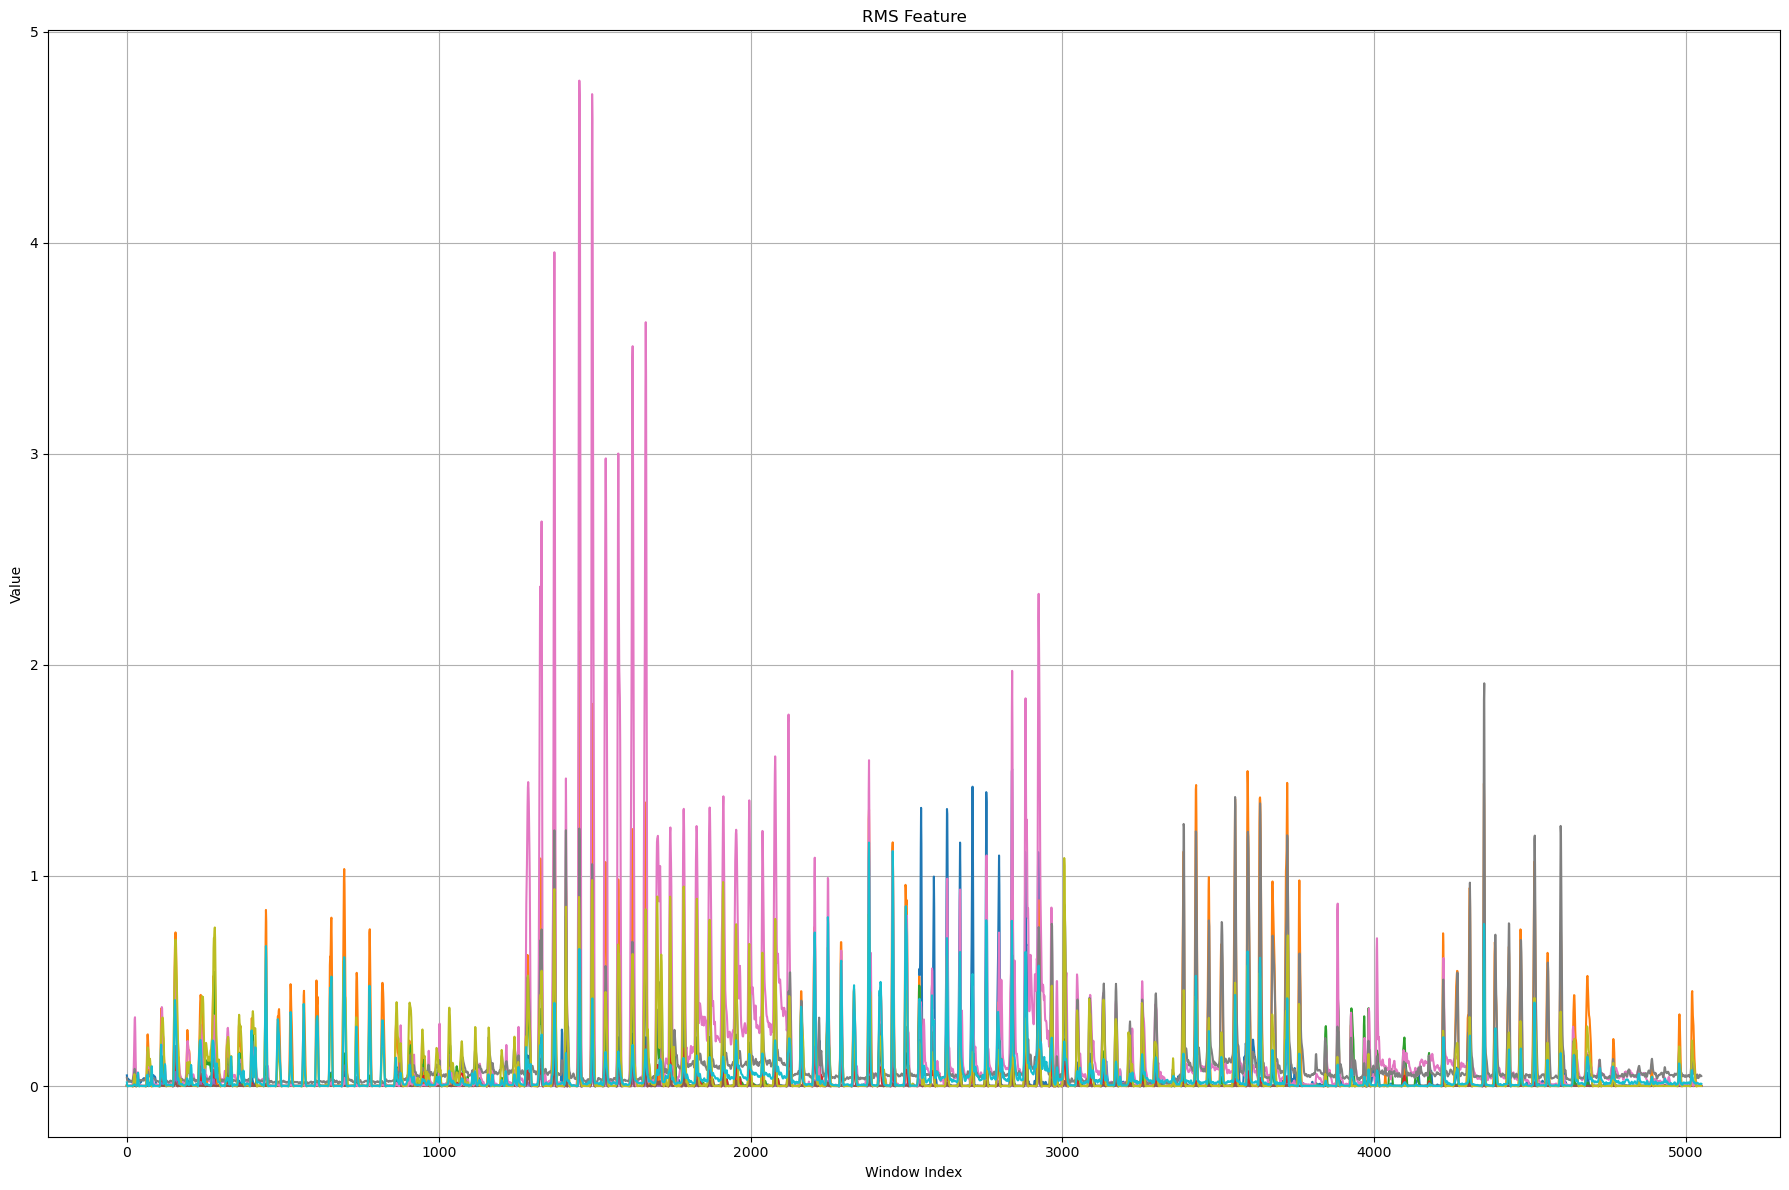

In [399]:
plt.figure(figsize=(18, 12))

for i, (feature_name, feature_data) in enumerate(features_1.items(), start=1):
    plt.subplot(len(features_1), 1, i)
    plt.plot(feature_data)
    plt.title(f"{feature_name} Feature")
    plt.xlabel("Window Index")
    plt.ylabel("Value")
    plt.grid(True)

plt.tight_layout()
plt.show()